In [1]:
'''A test of the toy example for the block particle filter from Kidus Asfaw's notes. 
https://kidusasfaw.github.io/spatPomp/vignettes/ibpf.pdf
'''

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.special import logsumexp

rng = np.random.default_rng(0)

U = 20 #The number of spatial locations

sig2 = 1.
tau2 = 5.
rho = 0.8


In [2]:
'''Simulate the model'''

delta_t = 0.1
t_range = np.arange(0.,200+delta_t,delta_t)

X = np.zeros((len(t_range),U))
Y = np.zeros((len(t_range),U))

def dist(u, u_hat, U):
    return min([
        abs(u - u_hat),
        abs(u - u_hat + U),
        abs(u - u_hat - U)
    ])

# Precompute the spatial weight matrix  W[u, u_hat] = rho ** dist(u, u_hat)
W = np.zeros((U, U))
for u in range(U):
    for u_hat in range(U):
        W[u, u_hat] = rho ** dist(u, u_hat, U)


for t in range(1,len(t_range)): 

    eps = np.sqrt(sig2) * rng.normal(0,scale = np.sqrt(delta_t), size = U)

    X[t,:] = X[t-1,:] + W @ eps

    Y[t,:] = X[t,:] + rng.normal(scale = np.sqrt(tau2), size = U)


In [3]:
'''As this is a linear gaussian model, compute the log likelihood via the Kalman Filter'''

F = np.eye(U)
H = np.eye(U)
R_fwd = W @ (sig2 * delta_t * np.eye(U)) @ W.T
R_obs = tau2 * np.eye(U)

m0 = np.zeros(U)
R0 = np.eye(U)

m_prior = np.zeros((len(t_range),U))
m_prior[0,:] = m0

R_prior = np.zeros((len(t_range),U,U))
R_prior[0,:,:] = R0

m_post = np.zeros((len(t_range),U))
R_post = np.zeros((len(t_range),U,U))

LL = np.zeros(len(t_range))

for index,obs in enumerate(Y): 
    if index > 0: 
        m_prior[index,:] = F @ m_post[index-1,:]
        R_prior[index,:,:] = F @ R_post[index-1,:,:] @ F.T + R_fwd

    LL[index] = multivariate_normal.logpdf(obs,mean = H @ m_prior[index,:], cov = H @ R_prior[index,:,:] @ H.T + R_obs)

    K = R_prior[index,:,:] @ H.T @ np.linalg.pinv(H @ R_prior[index,:,:] @ H.T + R_obs)
    m_post[index,:] = m_prior[index,:] + K @ (obs - H @ m_prior[index,:])
    R_post[index,:,:] = R_prior[index,:,:] - K @ H @ R_prior[index,:,:]


Log likelihood estimate from the particle filter: -91684.42950347447


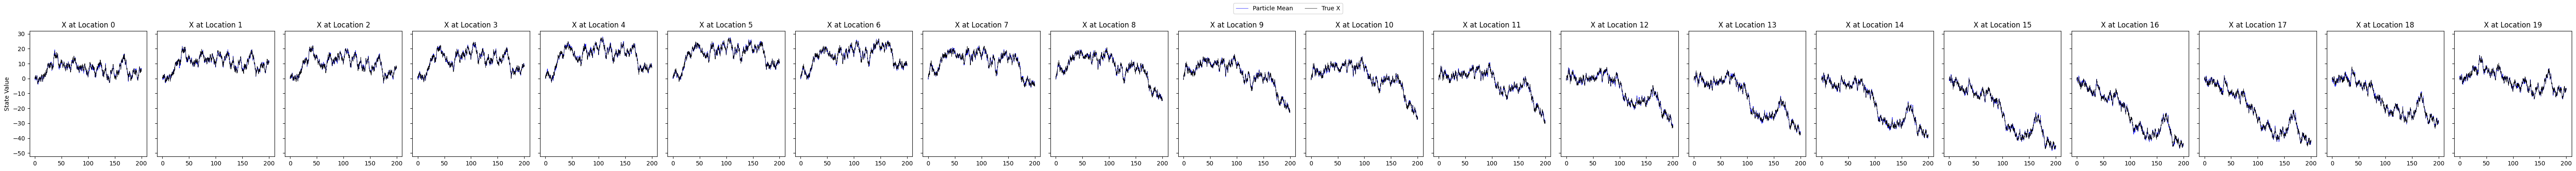

In [4]:
# Create a row of U subplots
fig, ax = plt.subplots(
    ncols=U,
    sharey=True,
    figsize=(3 * U, 4)     # scale width with number of locations
)

# Ensure ax is always a 1D array (even if U = 1)
if U == 1:
    ax = [ax]

print(f"Log likelihood estimate from the particle filter: {np.sum(LL)}")

# Precompute particle means (T x U)
for i in range(U):
    ax[i].set_title(f"X at Location {i}")

    ax[i].plot(t_range, m_post[:,i], lw=0.5, color='blue', label='Particle Mean')
    ax[i].plot(t_range, X[:, i], lw=0.5, color='black', label='True X')

    if i == 0:
        ax[i].set_ylabel("State Value")

# Create a single figure-level legend
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2)

# Improve layout, leaving room for legend
fig.tight_layout(rect=[0, 0, 1, 0.92])

plt.show()


In [ ]:
'''Particle filter approximation'''
num_particles = 100
block_indices = [[i,i+1] for i in range(0,U-1,2)]
num_blocks = len(block_indices)

particles = np.zeros((len(t_range),U,num_particles))
weights = np.full((num_particles,num_blocks),fill_value = -np.log(num_particles))

LL_pf = np.zeros(len(t_range))

for index,obs in enumerate(Y): 

    '''Forward model'''
    if index > 0: 
        particles[index,:,:] = F @ particles[index-1,:,:] + rng.multivariate_normal(mean = np.zeros(U),cov = R_fwd,size = (num_particles,)).T

    '''Weighting and resampling'''
    for block in range(num_blocks): 
        for particle_index in range(num_particles):
            mean = particles[index,block_indices[block],particle_index]
            weights[particle_index,block] = multivariate_normal.logpdf(obs[block_indices[block]],mean = mean,cov = tau2 * np.eye(len(obs[block_indices[block]])))

        #Normalize weights 
        LL_pf[index] += logsumexp(weights[:,block]) - np.log(num_particles)

        weights[:,block] = weights[:,block] - logsumexp(weights[:,block])
        indices = rng.choice(a = np.arange(0,num_particles),replace = True, p = np.exp(weights[:,block]),size = (num_particles,))

        block_state = particles[index,block_indices[block],:]

        particles[index,block_indices[block],:] = block_state[:,indices]


Log likelihood estimate from the particle filter: -37481.0704067531


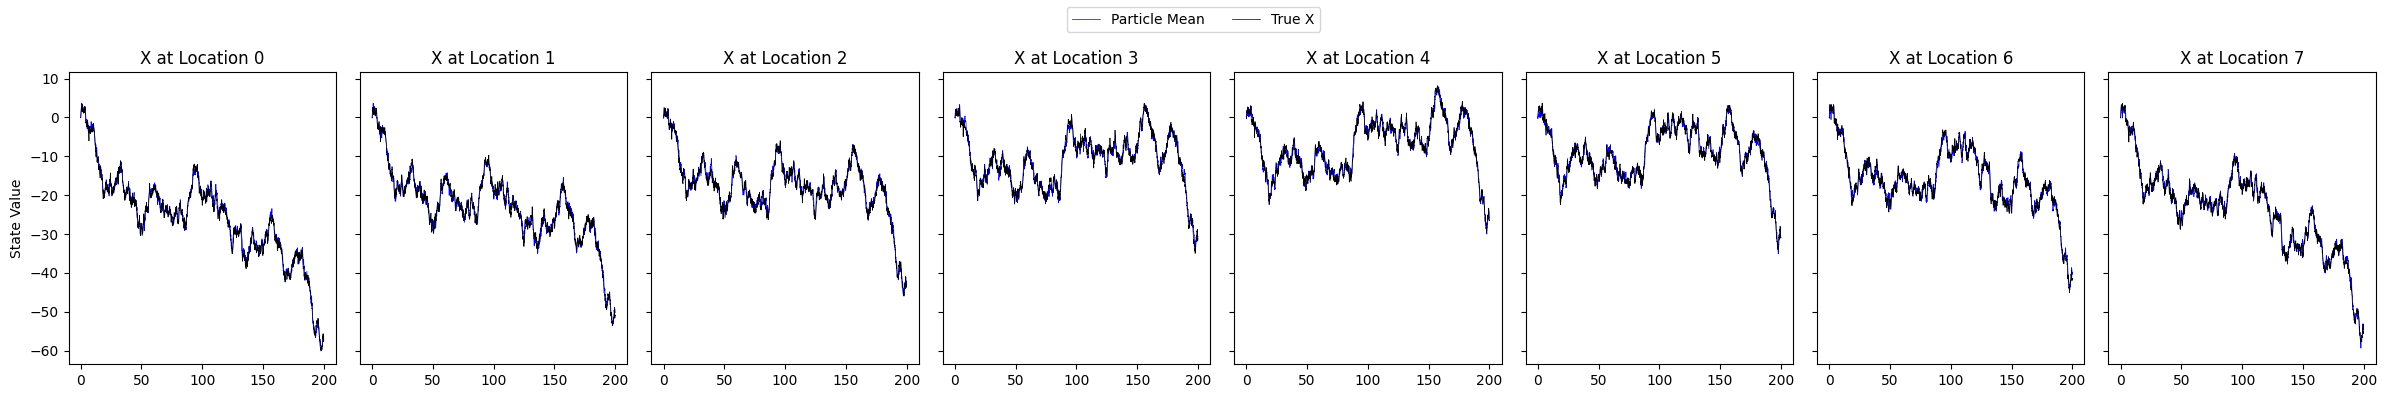

In [ ]:
# Create a row of U subplots
fig, ax = plt.subplots(
    ncols=U,
    sharey=True,
    figsize=(3 * U, 4)     # scale width with number of locations
)

# Ensure ax is always a 1D array (even if U = 1)
if U == 1:
    ax = [ax]

print(f"Log likelihood estimate from the particle filter: {np.sum(LL_pf)}")

# Precompute particle means (T x U)
x_mean = np.mean(particles, axis=2)

for i in range(U):
    ax[i].set_title(f"X at Location {i}")

    ax[i].plot(t_range, x_mean[:, i], lw=0.5, color='blue', label='Particle Mean')
    ax[i].plot(t_range, X[:, i], lw=0.5, color='black', label='True X')

    if i == 0:
        ax[i].set_ylabel("State Value")

# Create a single figure-level legend
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2)

# Improve layout, leaving room for legend
fig.tight_layout(rect=[0, 0, 1, 0.92])

plt.show()

